# 1. Loading and preprocessing<a class="anchor" id="1"></a><a class="anchor" id="1"></a>

In [35]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

# Create a list with the filepaths for training and testing
train_dir = Path('input/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))
train_filepaths += list(train_dir.glob(r'**/*.png'))

test_dir = Path('input/test')
test_filepaths = list(test_dir.glob(r'**/*'))
test_filepaths += list(test_dir.glob(r'**/*.png'))
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)

In [36]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')
num_classes = len(train_df.Label.unique())

-- Training set --

Number of pictures: 4657

Number of different labels: 5

Labels: ['potato' 'banana' 'apple' 'broccoli' 'carrot']


In [37]:
img_height = 224
img_width = 224

In [38]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

,Filepath,Label
0,input\train\potato\0471.jpg,potato
1,input\train\potato\0407.jpg,potato
2,input\train\banana\Banana02171.png,banana
3,input\train\banana\Banana02114.png,banana
4,input\train\potato\0031.jpg,potato


# 2. Load the Images with a generator and Data Augmentation<a class="anchor" id="2"></a>

In [39]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4657 validated image filenames belonging to 5 classes.
Found 1138 validated image filenames belonging to 5 classes.


c:\Users\profo\Documents\Checkitout\tf\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 5 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [40]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

# 3. Train the model<a class="anchor" id="3"></a>

In [41]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)

activation =  tf.keras.activations.softmax #None  # tf.keras.activations.sigmoid or softmax
print(num_classes)
outputs = tf.keras.layers.Dense(num_classes,
                            kernel_initializer=initializer,
                            activation=activation)(x) 
model = tf.keras.Model(inputs, outputs)

5


In [42]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [43]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=test_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
146/146 [==============================] - 128s 846ms/step - loss: 0.1771 - accuracy: 0.9480 - val_loss: 0.0291 - val_accuracy: 0.9938
Epoch 2/5
146/146 [==============================] - 121s 829ms/step - loss: 0.0205 - accuracy: 0.9970 - val_loss: 0.0202 - val_accuracy: 0.9956
Epoch 3/5
146/146 [==============================] - 119s 812ms/step - loss: 0.0116 - accuracy: 0.9987 - val_loss: 0.0176 - val_accuracy: 0.9965
Epoch 4/5
146/146 [==============================] - 118s 806ms/step - loss: 0.0071 - accuracy: 0.9994 - val_loss: 0.0150 - val_accuracy: 0.9982
Epoch 5/5
146/146 [==============================] - 246s 2s/step - loss: 0.0049 - accuracy: 0.9996 - val_loss: 0.0148 - val_accuracy: 0.9974


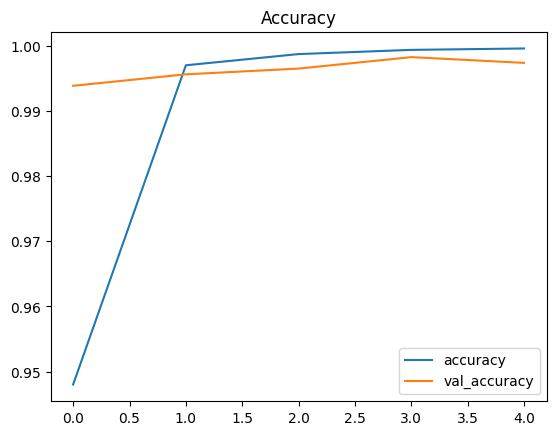

In [47]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

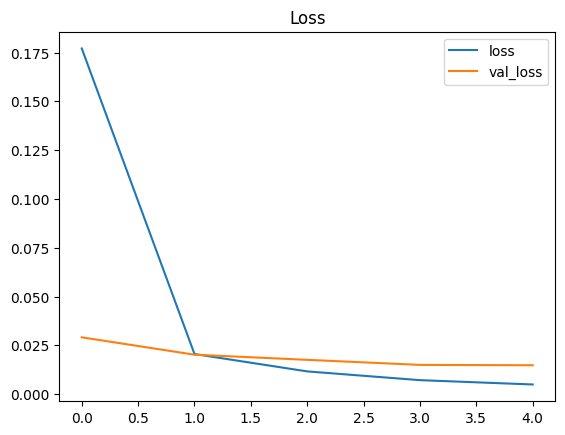

In [45]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# 4. Visualize the result<a class="anchor" id="4"></a>

In [53]:
model.save("mobilenet_v2_224x224.h5")

In [54]:
import tensorflow.keras as keras
from keras.models import load_model
model= load_model("mobilenet_v2_224x224.h5")

In [56]:
# Predict the label of the test_images
pred = model.predict(test_images)
print(pred[0])
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)
print(pred)
pred = [labels[k] for k in pred]
y_test = [labels[k] for k in test_images.classes]

36/36 [==============================] - 17s 465ms/step
[9.9874014e-01 4.9265398e-04 7.3130766e-04 1.7963379e-05 1.7991220e-05]
{0: 'apple', 1: 'banana', 2: 'broccoli', 3: 'carrot', 4: 'potato'}
[0 2 3 ... 4 1 0]


In [51]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 99.74%


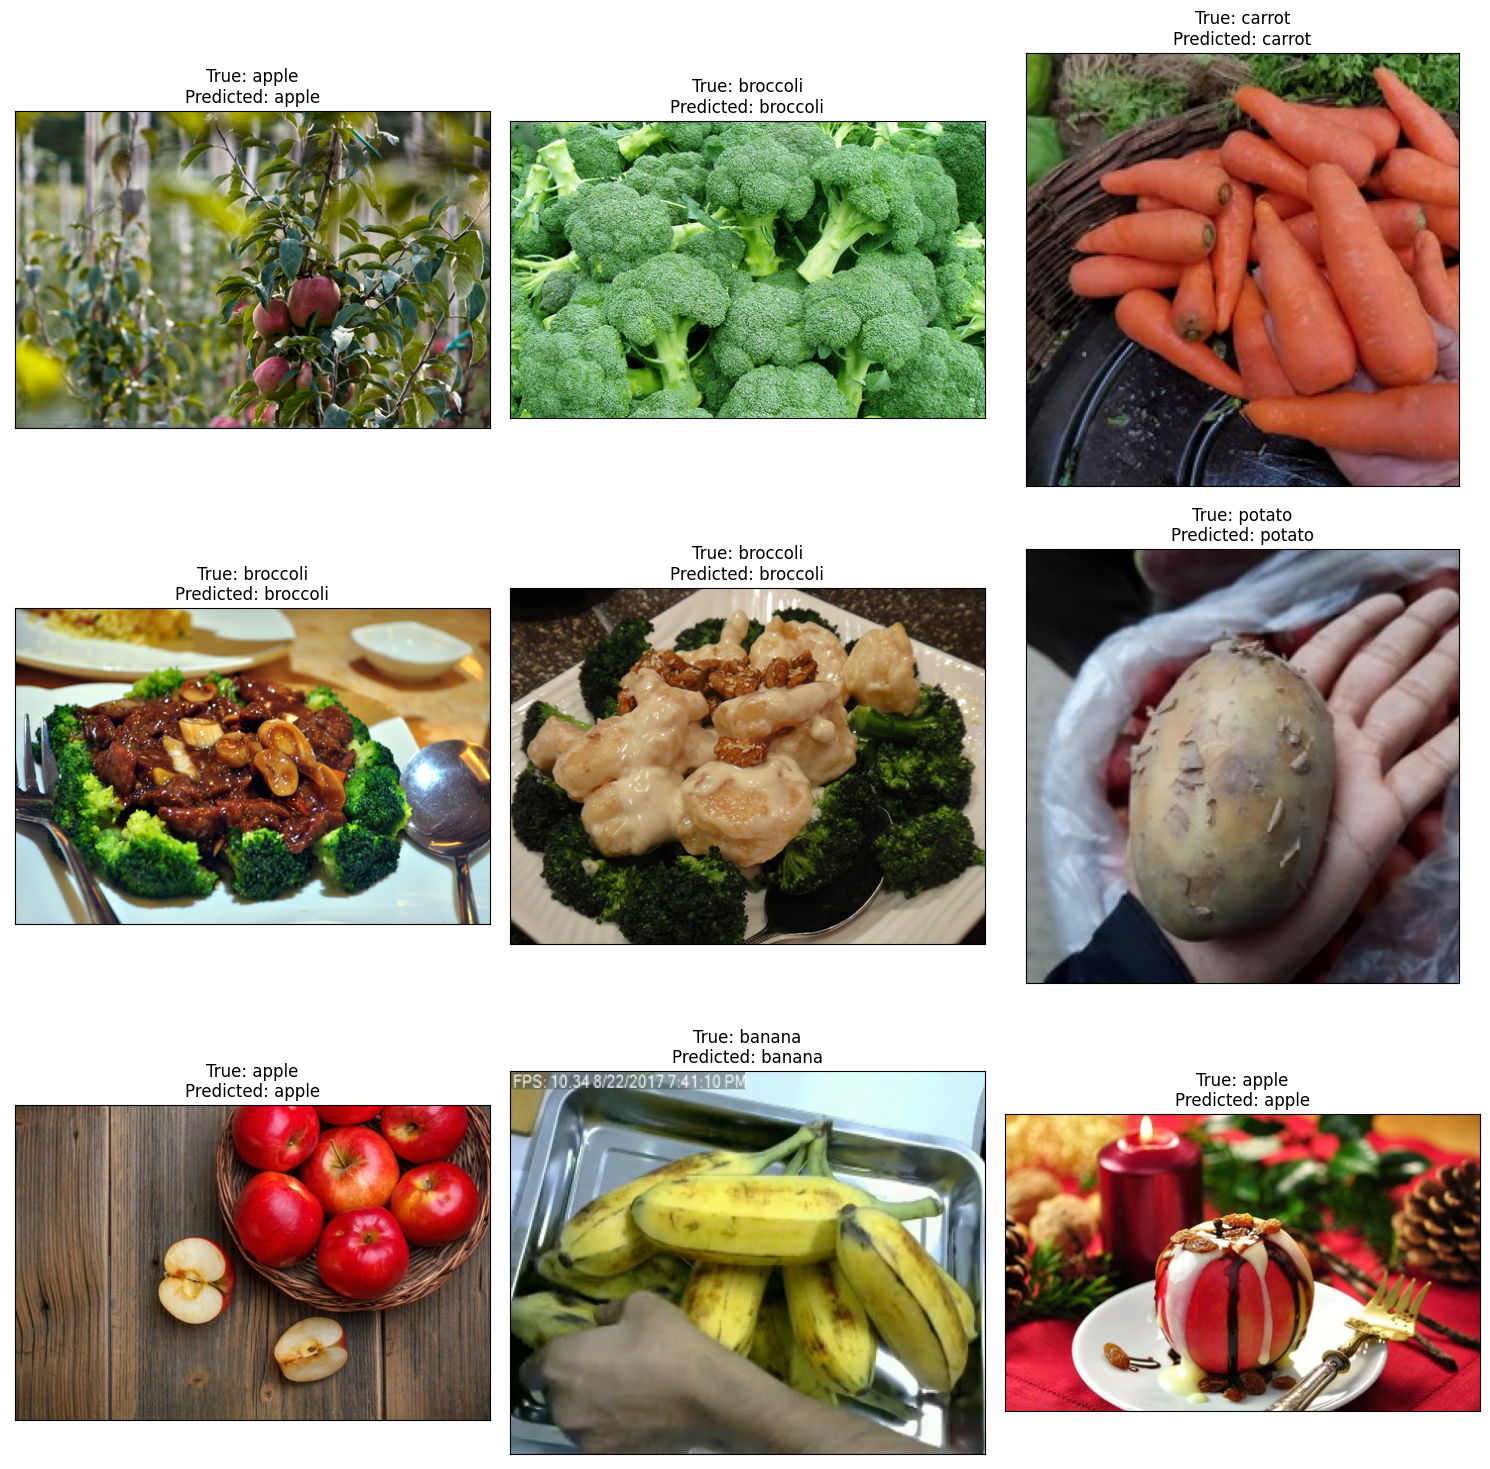

In [52]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
model.save("mobilenet_v2_224x224.h5")

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
from keras.utils import load_img

In [ ]:
loaded_model = load_model('mobilenet_v2_224x224.h5')
def predict_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    result=loaded_model.predict(img)
    maxval= np.argmax(result, axis =1)[0]
    return(labels[maxval])
path = "sample_img/testimg.jpg"
predict_image(path)